# HW3 Deep Learning CS-5787

#### Citations
- For this homework I have been using ChatGPT for general guidance on specific pytorch syntax and CS concepts.

## Problem 1 - BatchNorm (5 points)
Discuss the pros and cons of using BatchNorm. When does BatchNorm fail? Discuss
alternatives and their pros and cons. What properties would an ideal normalization method
have?

<font color='blue'> 
Answer:

<font color='blue'> 
Batch normalization is a very popular deep learning technique used to normalize the activations outputted by each layer in a mini-batch. Its main goals are to achieve faster training and better generalization, thus performance, for the network. 

<font color='blue'> 
However, BatchNorm comes with a higher memory cost and computational overhead, and its effectiveness is also quite sensitive to the chosen mini-batch size. For example, it is likely to produce poor results for small batch sizes.

<font color='blue'> 
Layer normalization (LN), Instance Normalization (IN), and Group Normalization (GN) are all valid alternatives to BatchNorm. LN's peculiarity is that it normalizes activations across the feature dimension. Compared to BatchNorm, is more suitable for small batch sizes. IN instead, normalizes activations across spatial dimensions. It is mainly used for style transfer or image generation tasks. GN finally, divides activations into groups and normalizes them both across spatial dimensions and within each group.

<font color='blue'> 
An ideal normalization method should combine computational efficiency, with flexibility and robustness. Moreover, it should be easy to use, and improve the model's generalization capabilities, without introducing additional complexity (in form of additional hyperparameters for example).

## Problem 2 - Using a Pre-Trained CNN (10 points total)
For this problem you must use PyTorch. For this problem you will use a CNN that has
been trained on ImageNet-1k. You may use any pre-trained architecture developed from
2014 onwards (e.g., not AlexNet, but a VGG or ResNet model would be fine). The CNN
needs to produce d-dimensional embeddings that are fed into the 1000-way output layer,
where d is typically 512, 2048, or 4096. You will be re-using the CNN you select in the
next problem for transfer learning with embeddings.

In [37]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device being used: {device}")

em_s, em_e = "\033[1m", "\033[0;0m"

Device being used: cuda


In [41]:
import numpy as np
import matplotlib.pyplot as plt
def format_plot(ax, xlab = "", ylab = "", title = "", legend = False, 
                xticks = None, yticks = None, no_scientific = True):
    
    ax.set_xlabel(xlab,  fontsize = 14)
    ax.set_ylabel(ylab,  fontsize = 14)
    ax.set_title(title,  fontsize = 16, fontweight = "bold")
    
    if no_scientific:
        ax.ticklabel_format(useOffset = False, style='plain')
    if legend:
        ax.legend(fontsize = 14)
    if xticks is not None:
        ax.set_xticks(xticks)
    if yticks is not None:
        ax.set_yticks(yticks)

In [42]:
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image

model = models.resnet50(pretrained = True)
model.eval()

print("ResNet-50 Model Loaded Successfully")

ResNet-50 Model Loaded Successfully


In [43]:
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

--2023-04-15 01:37:28--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt.3’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2023-04-15 01:37:28 (91.2 MB/s) - ‘imagenet_classes.txt.3’ saved [10472/10472]



### Part 1 - Using Pre-Trained Deep CNN (5 points)
Run it on peppers.jpg. Output the top-3 predicted categories and the probabilities. State
the pre-trained CNN model that you used.
Make sure to pre-process the input image appropriately. Look at the toolbox documenta-
tion for the pre-trained model you use to determine how to do this.


<font color='blue'> 
Answer:

(src for pre-processing steps: https://pytorch.org/hub/pytorch_vision_resnet/)


In [44]:
model = models.resnet18(weights = models.ResNet18_Weights.IMAGENET1K_V1)

model.eval()

img = Image.open("peppers.jpg")

resize, crop, mu, std = (256, 224, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

transform = transforms.Compose([
  transforms.Resize(resize),
  transforms.CenterCrop(crop),
  transforms.ToTensor(),
  transforms.Normalize(
    mean= mu,
    std = std
  )
])

img = transform(img).unsqueeze(0)

with torch.no_grad():
  out = model(img)

probs, indexes = torch.topk(torch.softmax(out, dim = 1), k = 3)

with open("imagenet_classes.txt", "r") as f:
  categories = [s.strip() for s in f.readlines()]

print(f"{em_s} Top three categories: {em_e}")
for i, idx in enumerate(indexes.squeeze()):
  print(f"{em_s} {categories[idx]}: {em_e} {round(float(probs.squeeze()[i]) * 100, 4)}%")

 Top three categories: 
 bell pepper:  99.7343%
 cucumber:  0.1794%
 Granny Smith:  0.0372%


### Part 2 - Visualizing Feature Maps (5 points)
Write code to visualize the feature maps in the network as images. You will likely need to
normalize the values between 0 and 1 to do this.
Choose five interesting feature maps from early in the network, five from the the middle of
the network, and five close to the end of the network. Display them to us and discuss
the structure of the feature maps. Try to find some that are interpretable, and discuss the
challenges in doing so.

<font color='blue'> 
Answer:


<font color='blue'> 
As we can see from the features visualized, early layers focus on identifying basic patterns, like detecting the edges of the bell peppers.

<font color='blue'> 
Middle layers, instead, start to hone in more complex patterns and peppers become more visible in the images. At this stage, the features are trying to learn information on parts of the object depicted and their structure, for example the shape, the texture, the color, the stems and so on.

<font color='blue'> 
Finally in the Late layers, features become more abstract and more difficult to interpret.

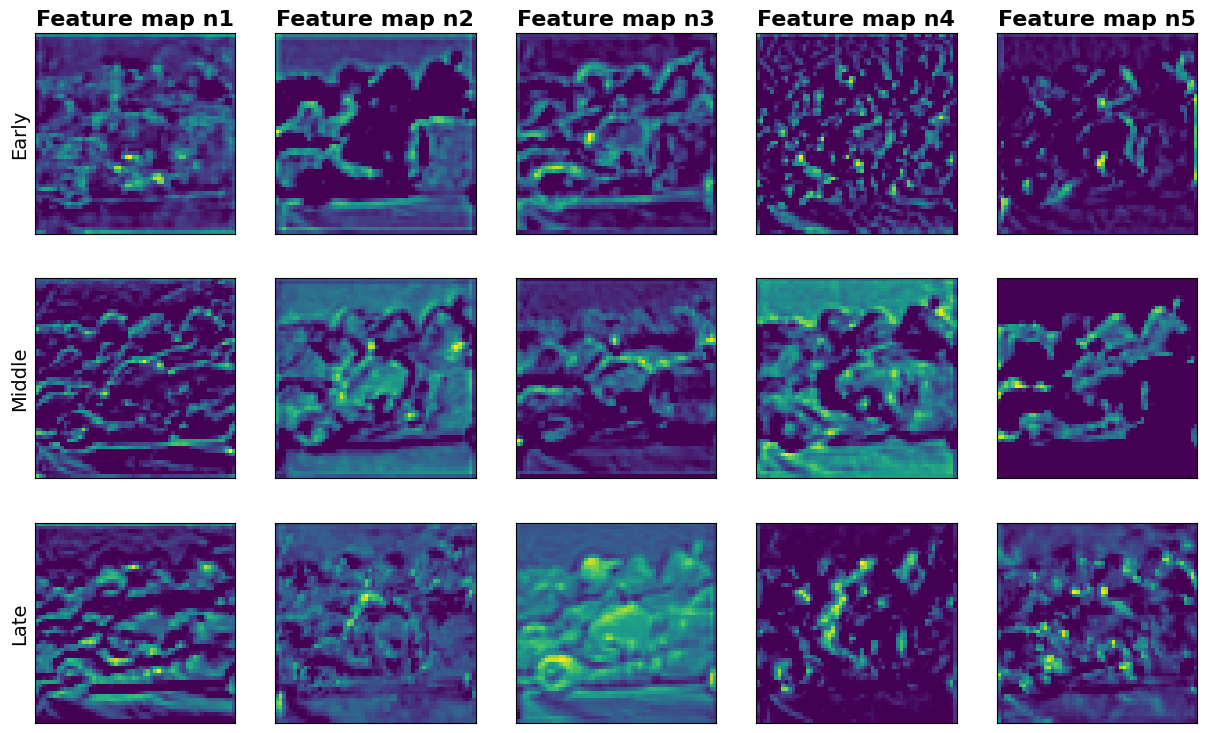

In [45]:
features = model.layer1(
             model.maxpool(
               model.relu(
                 model.bn1(
                   model.conv1(img)
                 )
               )
             )
           )

# Normalize feature maps between 0 and 1
features = (features - features.min()) / features.max()


# Plot first 5 feature maps
rows, cols = 3, 5
fig, ax = plt.subplots(rows, cols, figsize = (15, 9))
interesting_feats = np.array(
                      [[0, 6, 2, 3, 5], 
                      [29, 34, 31,  27, 33], 
                      [57, 55, 61, 62, 53]],
                      dtype = np.int32
                    )
for i in range(rows):
    for j in range(cols): 
        ylab = "Early" if i == 0 else ("Middle" if i == 1 else "Late")
        feat_i = interesting_feats[i, j]
        ax[i, j].imshow(features[0, feat_i].detach().numpy())
        format_plot(ax[i, j], ylab = ylab if j == 0 else "", 
                    xticks = [], yticks = [], 
                    title = "Feature map n" + str(j + 1) if i == 0 else "")
plt.show()

### Problem 3 - Transfer Learning with a Pre-Trained CNN (20 points)
For this problem you may use a toolbox (and you must use PyTorch). We will do image
classification using the Oxford Pet Dataset. The dataset consists of 37 categories with
about 200 images in each of them. You can find the dataset here: http://www.robots.ox.ac.uk/~vgg/data/pets/
Rather than using the final ‘softmax’ layer of the CNN as output to make predictions
as we did in problem 2, instead we will use the CNN as a feature extractor to classify
the Pets dataset. For each image, grab features from the last hidden layer of the neural
network, which will be the layer before the 1000-dimensional output layer (around 500–
6000 dimensions). You will need to resize the images to a size compatible with your
network (usually 224 × 224 × 3, but look at the documentation for the pre-trained system
you selected). You should grab the output just after the last hidden layer or after global
pooling (if it is 1000-dimensional, you will know you did it wrong).
After you extract these features for all of the images in the dataset, normalize them to
unit length by dividing by the L2 norm. Train a linear classifier of your choice1 with the
training CNN features, and then classify the test CNN features. Report mean-per-class
accuracy and discuss the classifier you used.

<font color='blue'> 
Answer:

<font color='blue'> 
The linear classifier used in the given code is a simple single-layer neural network implemented using PyTorch's nn.Linear module. The input to the classifier is the features extracted from the previous model and the output is a set of scores for each class.

<font color='blue'> 
The architecture of the linear classifier consists of a single linear layer with train_features.size(1) input features and len(train_data.classes) output features, where train_data.classes is the number of classes in the dataset. The linear layer is followed by a softmax activation function, which converts the output scores into a probability distribution over the classes.

<font color='blue'> 
The design of the linear classifier is relatively simple, with only one layer and a softmax activation function. The optimizer used is stochastic gradient descent (SGD) with momentum, and the loss function used is the cross-entropy loss. The classifier is trained for 20 epochs, and the mean per-class accuracy is reported as the performance metric.

In [12]:
import torchvision.datasets  as datasets
import torch.utils.data as data

resize, mu, std = (224, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

transform = transforms.Compose([
    transforms.Resize((resize, resize)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean= mu,
        std = std
    )
])

# set data loaders
root_path, batch_size, download = './data', 64, True

train_data = datasets.OxfordIIITPet(root = root_path, split = 'trainval', 
                                    transform = transform, download = download)
train_loader = data.DataLoader(train_data, batch_size = batch_size, shuffle = True)

test_data = datasets.OxfordIIITPet(root = root_path, split = 'test', 
                                   transform = transform, download = download)
test_loader = data.DataLoader(test_data, batch_size = batch_size, shuffle = False)

# define model
model = torch.nn.Sequential(
    *list(
        models.resnet18(
            weights = models.ResNet18_Weights.IMAGENET1K_V1
        ).children()
    )[:-1]
)

model.eval()

100%|██████████| 791918971/791918971 [00:03<00:00, 208507227.48it/s]


Extracting data/oxford-iiit-pet/images.tar.gz to data/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:00<00:00, 78647903.96it/s]


Extracting data/oxford-iiit-pet/annotations.tar.gz to data/oxford-iiit-pet


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [13]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score


def extract_norm_features(loader, model):
  features = []
  labels = []
  
  with torch.no_grad():
    for imgs, labs in loader:
      feats = model(imgs)
      features.append(feats.view(feats.size(0), -1))
      labels.append(labs)
  
  features = torch.cat(features, dim = 0)
  labels = torch.cat(labels, dim = 0)

  features = features / features.norm(dim = 1, keepdim = True)
  return features, labels


train_features, train_labels = extract_norm_features(train_loader, model)
test_features, test_labels = extract_norm_features(test_loader, model)


lin_model = nn.Linear(train_features.size(1), len(train_data.classes))

In [23]:
def train_and_test_part3(model, loss_func = nn.CrossEntropyLoss(), lr = 0.01, 
                         momentum = 0.9, epochs = 20):
  
  optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum = momentum)

  for epoch in range(epochs):
    
    model.train()
    loss_acc = 0
    
    for feats, labs in DataLoader(
        list(zip(train_features, train_labels)), batch_size = 32, shuffle = True):
      
      optimizer.zero_grad()
      outputs = model(feats)
      loss = loss_func(outputs, labs)
      
      loss.backward()
      optimizer.step()

      loss_acc += loss.item()
    print((
      f"{em_s} Epoch: {em_e} {epoch + 1},"  
      f"\t {em_s} Train Loss: {em_e} {round(loss_acc / len(train_loader), 4)},"
    ))

  model.eval()

  with torch.no_grad():
    outputs = model(test_features)

  predicted_labels = torch.argmax(outputs, dim = 1)
  accuracy = accuracy_score(test_labels, predicted_labels)

  class_accuracy = []
  for i in range(len(train_data.classes)):
      class_accuracy.append(accuracy_score(test_labels[test_labels == i], 
                            predicted_labels[test_labels == i]))

  print(f"{em_s} Mean Per Class Accuracy: {em_e} {round(np.mean(class_accuracy), 4)}")

  return class_accuracy, train_data.classes

In [15]:
part3_acc, part3_classes = train_and_test_part3(lin_model)

 Epoch:  1,	  Train Loss:  7.1184,
 Epoch:  2,	  Train Loss:  7.0119,
 Epoch:  3,	  Train Loss:  6.9063,
 Epoch:  4,	  Train Loss:  6.8023,
 Epoch:  5,	  Train Loss:  6.699,
 Epoch:  6,	  Train Loss:  6.5981,
 Epoch:  7,	  Train Loss:  6.499,
 Epoch:  8,	  Train Loss:  6.4021,
 Epoch:  9,	  Train Loss:  6.3057,
 Epoch:  10,	  Train Loss:  6.2115,
 Epoch:  11,	  Train Loss:  6.1183,
 Epoch:  12,	  Train Loss:  6.0277,
 Epoch:  13,	  Train Loss:  5.9377,
 Epoch:  14,	  Train Loss:  5.8498,
 Epoch:  15,	  Train Loss:  5.7634,
 Epoch:  16,	  Train Loss:  5.6784,
 Epoch:  17,	  Train Loss:  5.5946,
 Epoch:  18,	  Train Loss:  5.5125,
 Epoch:  19,	  Train Loss:  5.4323,
 Epoch:  20,	  Train Loss:  5.3532,
 Mean Per Class Accuracy:  0.8532


### Problem 4 - Training a Small CNN (55 points total)
#### Part 1 (25 points)
For this problem you must use a toolbox. Train a CNN with three hidden convolutional
layers that use the Mish activation function. Use 32 7 × 7 filters for the first layer, followed
by 2 × 2 max pooling (stride of 2). The next two convolutional layers will use 64 3 × 3
filters followed by the Mish activation function. Prior to the softmax layer, you should have
an average pooling layer that pools across the preceding feature map. Do not use a pre-
trained CNN. AdamW is the recommended optimizer, but you may try Ranger, RAdam,
or something else more recent if you would like, but you will probably have to add in an
external toolbox to do this. Tune your hyperparameters on a small version of the dataset
to make sure your training loss goes down and things are set up correctly.
Train your model using all of the CIFAR-10 training data, and evaluate your trained system
on the CIFAR-10 test data.

Visualize all of the 7 × 7 × 3 filters learned by the first convolutional layer as an RGB image
array (I suggest making a large RGB image that is made up of each of the smaller images).
This visualization of the filters should be similar to the ones we saw in class. Note that
you will need to normalize each filter to display them. Let Ht be the t’th filter learned by
the network. The normalized version $H^{'}_t$  for visualization is then given by
$$
H^{'}_t = \frac{H_t}{2(∥H_t∥_∞ + ε)} + \frac{1}{2},
$$

where $ε > 0$ (e.g., $ε = 0.0001$). This will make all values in the filter be values from 0 to 1
so that they can be displayed as an RGB image.

Display the training loss as a function of epochs. What is the accuracy on the test data?
How did you initialize the weights? What optimizer did you use? Discuss your architecture
and hyper-parameters.



<font color='blue'>   
Answer:  

<font color='blue'>   
The weights of a neural network are typically initialized randomly to avoid neuron symmetries, which impacts the generalization capabilities of the model. In PyTorch, the default weight initialization method for Conv2d and Linear layers is the Kaiming initialization, i.e. random weighting from a normal distribution with mean 0 and standard deviation sqrt(2 / num_input_channels). I have kept this as the weighting system for my implementation.

<font color='blue'>   
The optimizer AdamW is a variant of the Adam optimizer that utilizes weight decay regularization during the weight update step. This generally improves generalization performance by avoiding overfitting.
However, AdamW's computational cost is significant, if compared to simpler optimization algorithms, which can exponentially raise the execution timee, specially when training on large datasets or with complex models. Ultimately, the model here defined is simple enough to make the use of AdamW feasible.


<font color='blue'>   
The architecture of the SmallCNN model consists of three convolutional layers with batch normalization and a max-pooling layer followed by a linear layer with softmax activation. The Mish activation function is used in all layers of the network. The model takes as input 3-channel images (RGB) and produces the probability distribution for that input for each of the 10 output classes. 
The hyperparameters for the model include the learning rate (lr) and weight decay (wd) used in the AdamW optimizer, the loss function, and the number of epochs. While the loss used is standard for multi-class classification problems, the other hyperparameters discussed have been fine-tuned manually. 

In [46]:
import numpy as np
import matplotlib.pyplot as plt
def format_plot(ax, xlab = "", ylab = "", title = "", legend = False, 
                xticks = None, yticks = None, no_scientific = True):
    
    ax.set_xlabel(xlab,  fontsize = 14)
    ax.set_ylabel(ylab,  fontsize = 14)
    ax.set_title(title,  fontsize = 16, fontweight = "bold")
    
    if no_scientific:
        ax.ticklabel_format(useOffset = False, style='plain')
    if legend:
        ax.legend(fontsize = 14)
    if xticks is not None:
        ax.set_xticks(xticks)
    if yticks is not None:
        ax.set_yticks(yticks)

In [47]:
# Define CNN
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

class Mish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x * torch.tanh(nn.functional.softplus(x))

class SmallCNN(nn.Module):
    def __init__(self, use_batch_norm = False):
        super(SmallCNN, self).__init__()
        self.use_batch_norm = use_batch_norm

        self.conv1 = nn.Conv2d(3, 32, 7)
        self.bn1 = nn.BatchNorm2d(32)
        self.maxpool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, 3)
        self.bn3 = nn.BatchNorm2d(64)
        self.avgpool = nn.AdaptiveAvgPool2d(output_size = (1, 1))
        self.fc = nn.Linear(64, 10)
        self.mish = Mish()
        self.softmax = nn.Softmax(dim = 1)

    
    def forward(self, x):
        x = self.conv1(x)
        if self.use_batch_norm:
            x = self.bn1(x)
        x = self.mish(x)
        x = self.maxpool(x)
        
        x = self.conv2(x)
        if self.use_batch_norm:
            x = self.bn2(x)
        x = self.mish(x)

        x = self.conv3(x)
        if self.use_batch_norm:
            x = self.bn3(x)
        x = self.mish(x)
        x = self.avgpool(x)
        
        x = x.view(x.size(0), -1)
        x = self.softmax(x)
        return x

In [48]:
# Load Data
transform_norm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

def load_data(dataset = "CIFAR10", root = "./data", train = True, 
              download = True, transform = transform_norm,
              batch_size = 128, num_workers = 2):  
    
    if dataset == "CIFAR10":
        data = datasets.CIFAR10(root = root, train = train, download = download, 
                            transform = transform)
        loader = DataLoader(data, batch_size = batch_size, 
                        shuffle = train, num_workers = num_workers)
    return data, loader

train_data, train_loader = load_data(train = True)
test_data, test_loader = load_data(train = False)

100%|██████████| 170498071/170498071 [00:06<00:00, 26978270.85it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [49]:
import matplotlib.pyplot as plt

# Train and Test CNN
def train_and_test_CNN(net, train_loader, test_loader, 
                       lr = 0.001, wd = 0.1, 
                       loss_func = nn.CrossEntropyLoss(), epochs = 20):

    net.to(device)
    optimizer = optim.AdamW(net.parameters(), lr = lr, weight_decay = wd)

    correct_train_preds = 0
    train_count = 0
    train_loss_arr = []
    test_loss_arr = []
    
    for epoch in range(epochs):
        
        loss_acc = 0
        for data in train_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outs = net(inputs)
            _, pred = torch.max(outs.data, 1)
            train_loss = loss_func(outs, labels)

            train_loss.backward()
            optimizer.step()
            loss_acc += train_loss.item()

            train_count += labels.size(0)
            correct_train_preds += (pred == labels).sum().item()

        train_loss_arr.append(loss_acc / len(train_loader))

        correct_test_preds = 0
        loss_acc = 0
        test_count = 0
        
        with torch.no_grad():
            for data in test_loader:
                imgs, labels = data
                imgs, labels = imgs.to(device), labels.to(device)
                outs = net(imgs)
                _, pred = torch.max(outs.data, 1)

                test_loss = loss_func(outs, labels)
                loss_acc += test_loss.item()

                test_count += labels.size(0)
                correct_test_preds += (pred == labels).sum().item()


        test_loss_arr.append(loss_acc / len(test_loader))

        print((
          f"{em_s} Epoch: {em_e} {epoch + 1},"  
          f"\t {em_s} Train Loss: {em_e} {round(train_loss_arr[-1], 4)},"
          f"\t {em_s} Test Loss: {em_e} {round(test_loss_arr[-1], 4)},"  
          f"\t {em_s} Train Accuracy: {em_e}: {round(100 * correct_train_preds / train_count, 4)}%,"
          f"\t {em_s} Test Accuracy: {em_e}: {round(100 * correct_test_preds / test_count, 4)}%"
        ))

    fig, ax = plt.subplots(1, 1, figsize = (9, 6))
    ax.plot(train_loss_arr, label='Train', color = "blue")
    ax.plot(test_loss_arr, label='Test', color = "navy")

    format_plot(ax, xlab = "Epochs", ylab = "Cross Entropy Loss", 
    title = "Small CNN Performance", legend = True)
    plt.show()


 Epoch:  1,	  Train Loss:  3.9626,	  Test Loss:  3.9348,	  Train Accuracy: : 23.024%,	  Test Accuracy: : 25.31%
 Epoch:  2,	  Train Loss:  3.908,	  Test Loss:  3.8867,	  Train Accuracy: : 25.54%,	  Test Accuracy: : 30.19%
 Epoch:  3,	  Train Loss:  3.8806,	  Test Loss:  3.8836,	  Train Accuracy: : 27.326%,	  Test Accuracy: : 30.5%
 Epoch:  4,	  Train Loss:  3.8679,	  Test Loss:  3.8597,	  Train Accuracy: : 28.512%,	  Test Accuracy: : 33.05%
 Epoch:  5,	  Train Loss:  3.8521,	  Test Loss:  3.8453,	  Train Accuracy: : 29.5516%,	  Test Accuracy: : 34.27%
 Epoch:  6,	  Train Loss:  3.8388,	  Test Loss:  3.8404,	  Train Accuracy: : 30.4897%,	  Test Accuracy: : 34.78%
 Epoch:  7,	  Train Loss:  3.8309,	  Test Loss:  3.8287,	  Train Accuracy: : 31.2651%,	  Test Accuracy: : 36.43%
 Epoch:  8,	  Train Loss:  3.8249,	  Test Loss:  3.8269,	  Train Accuracy: : 31.9222%,	  Test Accuracy: : 36.31%
 Epoch:  9,	  Train Loss:  3.815,	  Test Loss:  3.8236,	  Train Accuracy: : 32.5471%,	  Test Accuracy: 

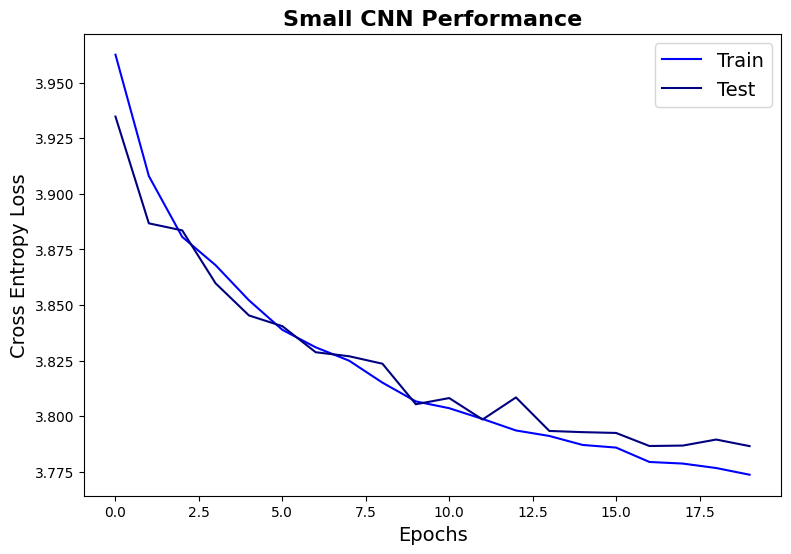

In [50]:
# Run Training and Testing
small_cnn = SmallCNN()
train_and_test_CNN(small_cnn, train_loader, test_loader)

In [51]:
def normalize_filters(filters, eps = 0.0001):
    return [(filter / (2 * (filters.abs().max() + eps))) + 0.5 for filter in filters]

def print_first_conv2d_filters(net, rows = 4, cols = 8):
    name, mod = None, None
    for n, m in net.named_modules():
        if isinstance(m, torch.nn.Conv2d):
            name = n
            mod = m
            break 

    if mod is not None:
        norm_filters = normalize_filters(mod.weight.data)
        fig, ax = plt.subplots(rows, cols, figsize = (10, 5))
        for i in range(rows):
            for j in range(cols):
                ax[i, j].imshow(norm_filters[i * 8 + j].permute(1, 2, 0).cpu().numpy())

                format_plot(ax[i, j], xticks = [], yticks = [])
        
        plt.suptitle(f'{name} filters')
        plt.show()

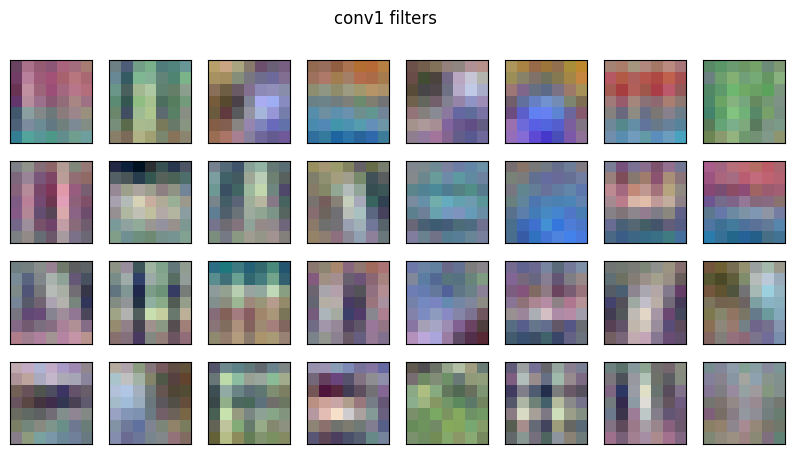

In [52]:
print_first_conv2d_filters(small_cnn)

### Part 2 (20 points)
Using the same architecture as in part 1, add in batch normalization between each of
the hidden layers. Compare the training loss with and without batch normalization as a
function of epochs. What is the final test accuracy? Visualize the filters.

<font color='blue'> 
Answer:


 Epoch:  1,	  Train Loss:  4.0881,	  Test Loss:  4.0334,	  Train Accuracy: : 31.708%,	  Test Accuracy: : 38.86%
 Epoch:  2,	  Train Loss:  3.9785,	  Test Loss:  3.9276,	  Train Accuracy: : 37.294%,	  Test Accuracy: : 46.37%
 Epoch:  3,	  Train Loss:  3.8785,	  Test Loss:  3.8394,	  Train Accuracy: : 41.392%,	  Test Accuracy: : 52.21%
 Epoch:  4,	  Train Loss:  3.8095,	  Test Loss:  3.7913,	  Train Accuracy: : 44.347%,	  Test Accuracy: : 53.88%
 Epoch:  5,	  Train Loss:  3.7609,	  Test Loss:  3.747,	  Train Accuracy: : 46.6676%,	  Test Accuracy: : 57.0%
 Epoch:  6,	  Train Loss:  3.7299,	  Test Loss:  3.7249,	  Train Accuracy: : 48.4643%,	  Test Accuracy: : 57.02%
 Epoch:  7,	  Train Loss:  3.7056,	  Test Loss:  3.7139,	  Train Accuracy: : 49.9331%,	  Test Accuracy: : 57.22%
 Epoch:  8,	  Train Loss:  3.6889,	  Test Loss:  3.6814,	  Train Accuracy: : 51.1205%,	  Test Accuracy: : 60.61%
 Epoch:  9,	  Train Loss:  3.6741,	  Test Loss:  3.6782,	  Train Accuracy: : 52.148%,	  Test Accuracy:

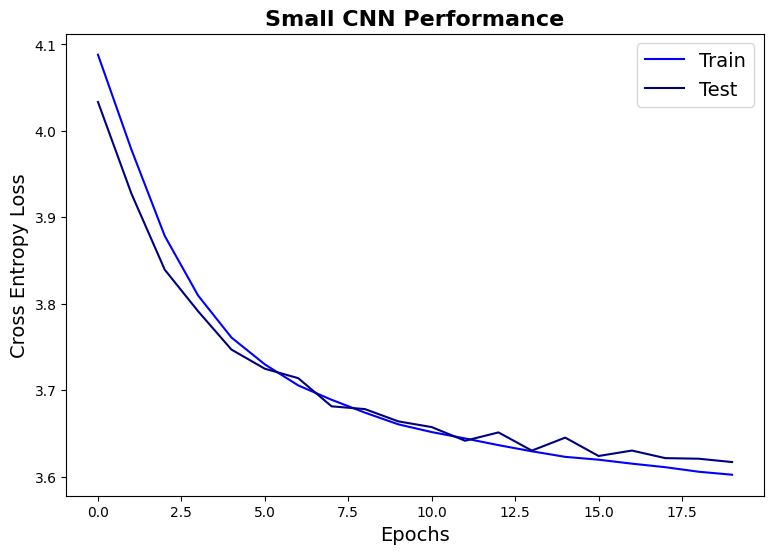

In [53]:
# Run Training and Testing
small_cnn_bn = SmallCNN(use_batch_norm = True)
train_and_test_CNN(small_cnn_bn, train_loader, test_loader)

In [ ]:
print_first_conv2d_filters(small_cnn_bn)

### Part 3 (10 points)
Can you do better with a deeper and better network architecture? Optimize your CNN’s
architecture to improve performance. You may get significantly better results by using
smaller filters for the first convolutional layer. Describe your model’s architecture and
your design choices. What is your final accuracy?
Note: Your model should perform better than the one in Part 1 and Part 2.

<font color='blue'> 
Answer:

<font color='blue'> 
In this question I have created a slightly deeper, more complex CNN.
I opted for conv2d layers increasing in size, where the first has a output of size 32 and increases by powers of two gradually for each convolution layer. Furthermore, the first convolution layer has 7x7 filters, while all others 3x3.
Every convolution layer is followed by a batchNorm layer for normalization. Finally, a adaptive average pool layer and a linear layer reconduct the output back to size 10 (one per class), which is then passed through a Mish activation and finally through a Dropout layer with rate 0.2 and a Softmax to turn the outputs in 0-1 probabilities.

<font color='blue'> 
Compared to the previous parts, the model is a bit more complex, hence performs slightly better. Concerning hyperparameters tuning, the only extra hyperparameter that I manually tuned in this question is the dropout rate.

In [ ]:
# Define Bigger CNN Model

class MediumCNN(nn.Module):
    def __init__(self, use_batch_norm = True, dropout_rate = 0.2):
        super(MediumCNN, self).__init__()
        self.use_batch_norm = use_batch_norm

        self.conv1 = nn.Conv2d(3, 32, 7)
        self.bn1 = nn.BatchNorm2d(32)
        self.maxpool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 64, 3)
        self.bn3 = nn.BatchNorm2d(64)
        
        self.conv4 = nn.Conv2d(64, 128, 3)
        self.bn4 = nn.BatchNorm2d(128)
        
        self.conv5 = nn.Conv2d(128, 128, 3)
        self.bn5 = nn.BatchNorm2d(128)
        
        self.conv5 = nn.Conv2d(128, 256, 3)
        self.bn5 = nn.BatchNorm2d(256)
        
        self.conv6 = nn.Conv2d(256, 256, 3)
        self.bn6 = nn.BatchNorm2d(256)
        
        self.avgpool = nn.AdaptiveAvgPool2d(output_size = (1, 1))
        self.fc = nn.Linear(256, 10)
        self.mish = Mish()

        self.dropout = nn.Dropout(dropout_rate)
        self.softmax = nn.Softmax(dim = 1)

    
    def forward(self, x):
        x = self.conv1(x)
        if self.use_batch_norm:
            x = self.bn1(x)
        x = self.mish(x)
        x = self.maxpool(x)
        
        x = self.conv2(x)
        if self.use_batch_norm:
            x = self.bn2(x)
        x = self.mish(x)

        x = self.conv3(x)
        if self.use_batch_norm:
            x = self.bn3(x)
        x = self.mish(x)
        
        x = self.conv4(x)
        if self.use_batch_norm:
            x = self.bn4(x)
        x = self.mish(x)

        x = self.conv5(x)
        if self.use_batch_norm:
            x = self.bn5(x)
        x = self.mish(x)

        x = self.conv6(x)
        if self.use_batch_norm:
            x = self.bn6(x)
        x = self.mish(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x


 Epoch:  1,	  Train Loss:  1.3992,	  Test Loss:  1.2045,	  Train Accuracy: : 49.366%,	  Test Accuracy: : 57.74%
 Epoch:  2,	  Train Loss:  1.0927,	  Test Loss:  1.048,	  Train Accuracy: : 55.231%,	  Test Accuracy: : 63.36%
 Epoch:  3,	  Train Loss:  0.9605,	  Test Loss:  0.9391,	  Train Accuracy: : 58.7173%,	  Test Accuracy: : 66.8%
 Epoch:  4,	  Train Loss:  0.8681,	  Test Loss:  0.9003,	  Train Accuracy: : 61.3645%,	  Test Accuracy: : 68.3%
 Epoch:  5,	  Train Loss:  0.7958,	  Test Loss:  0.8296,	  Train Accuracy: : 63.4336%,	  Test Accuracy: : 70.86%
 Epoch:  6,	  Train Loss:  0.7345,	  Test Loss:  0.8053,	  Train Accuracy: : 65.225%,	  Test Accuracy: : 71.67%
 Epoch:  7,	  Train Loss:  0.6894,	  Test Loss:  0.8124,	  Train Accuracy: : 66.7214%,	  Test Accuracy: : 72.16%
 Epoch:  8,	  Train Loss:  0.6441,	  Test Loss:  0.7739,	  Train Accuracy: : 68.0498%,	  Test Accuracy: : 73.1%
 Epoch:  9,	  Train Loss:  0.6133,	  Test Loss:  0.7557,	  Train Accuracy: : 69.2144%,	  Test Accuracy:

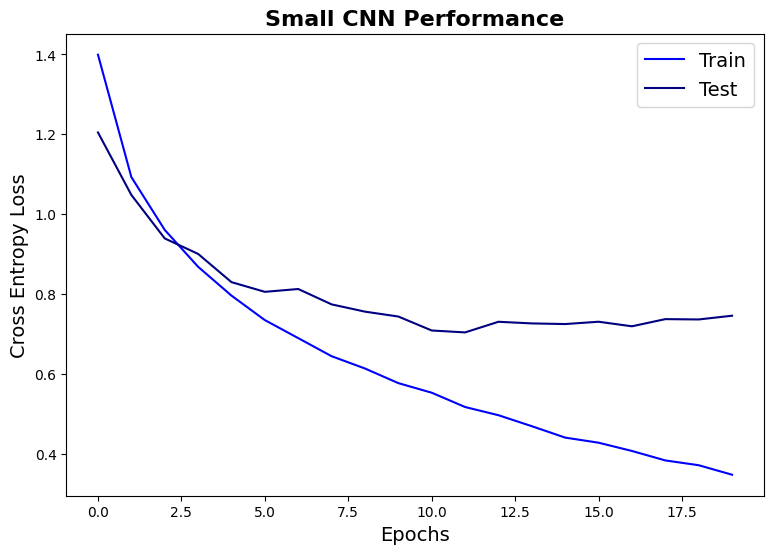

In [56]:
medium_cnn = MediumCNN()
train_and_test_CNN(medium_cnn, train_loader, test_loader)

### Problem 5 - Vision Transformers (20 points)
In this problem, you will redo problem 3, but instead of transfer learning with a CNN, you
will do transfer learning with a Vision Transformer. Identify a strong vision transformer
architecture for transfer learning that was pre-trained on ImageNet-1K (note that some
pre-trained models are pre-trained on larger datasets). We suggest using Swin Transformers
or later incarnations of them. You will have to download the pre-trained model and the
appropriate code.
Briefly discuss the Vision Transformer you selected. Compare performance of the Vision
Transformer to the CNN you used earlier in terms of overall performance. Are there
some images that the CNN gets correct but the Swin Transformer misclassifies, and vice
versa?


<font color='blue'> 
Answer:

<font color='blue'>
For this question I have used the vision transformer "Swin Transformer" with base architecture (swin_base_patch4_window7_224). This is a recent transformer-based architecture for image classification, proposed in the paper "Swin Transformer: Hierarchical Vision Transformer using Shifted Windows". It uses an innovative method to partition the image in patches using shifted windows in a complex hierarchy of several Swin Transformer blocks. Each building block includes this shifted window-based self-attention mechanism and a standard feed-forward network.

In [18]:
import torch.nn as nn
import torch.optim as optim
import timm
import torchvision.transforms as transforms
import torchvision.datasets as datasets

resize, mu, std = (224, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

transform = transforms.Compose([
    transforms.Resize((resize, resize)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean= mu,
        std = std
    )
])

# set data loaders
root_path, batch_size, download = './data', 64, True

train_data = datasets.OxfordIIITPet(root = root_path, split = 'trainval', 
                                    transform = transform, download = download)
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True)

test_data = datasets.OxfordIIITPet(root = root_path, split = 'test', 
                                   transform = transform, download = download)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = False)


swin_model = timm.create_model('swin_base_patch4_window7_224', pretrained = True)

train_features, train_labels = extract_norm_features(train_loader, swin_model)
test_features, test_labels = extract_norm_features(test_loader, swin_model)


Downloading: "https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_base_patch4_window7_224_22kto1k.pth" to /root/.cache/torch/hub/checkpoints/swin_base_patch4_window7_224_22kto1k.pth


In [27]:
lin_swin_model = nn.Linear(train_features.size(1), len(train_data.classes))
part5_acc, part5_classes = train_and_test_part3(lin_swin_model)

 Epoch:  1,	  Train Loss:  7.0364,
 Epoch:  2,	  Train Loss:  6.7465,
 Epoch:  3,	  Train Loss:  6.4629,
 Epoch:  4,	  Train Loss:  6.1875,
 Epoch:  5,	  Train Loss:  5.9209,
 Epoch:  6,	  Train Loss:  5.6636,
 Epoch:  7,	  Train Loss:  5.415,
 Epoch:  8,	  Train Loss:  5.1762,
 Epoch:  9,	  Train Loss:  4.9473,
 Epoch:  10,	  Train Loss:  4.7285,
 Epoch:  11,	  Train Loss:  4.5202,
 Epoch:  12,	  Train Loss:  4.3216,
 Epoch:  13,	  Train Loss:  4.1338,
 Epoch:  14,	  Train Loss:  3.9558,
 Epoch:  15,	  Train Loss:  3.7884,
 Epoch:  16,	  Train Loss:  3.6299,
 Epoch:  17,	  Train Loss:  3.4813,
 Epoch:  18,	  Train Loss:  3.3418,
 Epoch:  19,	  Train Loss:  3.211,
 Epoch:  20,	  Train Loss:  3.0889,
 Mean Per Class Accuracy:  0.9144


In [36]:
import pandas as pd

table = pd.DataFrame()
table["index"] = part3_classes
table["CNN"] = part3_acc
table["SWIN"] = part5_acc

display(table)

,index,CNN,SWIN
0,Abyssinian,0.704082,0.938776
1,American Bulldog,0.840000,0.850000
2,American Pit Bull Terrier,0.390000,0.670000
3,Basset Hound,1.000000,0.960000
4,Beagle,0.500000,0.950000
5,Bengal,0.790000,0.910000
6,Birman,0.760000,0.730000
7,Bombay,0.886364,1.000000
8,Boxer,0.939394,0.919192
9,British Shorthair,0.840000,0.670000


Compare performance of the Vision
Transformer to the CNN you used earlier in terms of overall performance. Are there
some images that the CNN gets correct but the Swin Transformer misclassifies, and vice
versa?

 <font color='blue'> 
Answer:

 <font color='blue'> 
 The comparison between CNN and SWIN per class accuracy is shown above.
 CNN achieves a mean per class accuracy of 0.8532 while SWIN of 0.9144. As we can see from the table, SWIN generally achieves slightly better results. Some classes stood out, like Abyssinian, Beagle, Staffordshire Bull Terrier and Russian Blue in which CNN performs significantly worse than SWIN. However, there are some classes that CNN recognizes slightly better, like Ragdoll, in which both algorithms have trouble identifying the objecy though, and Basset Hound.


## Code Appendix
## BONUS PROBLEMS
## Problem 6 - BatchNorm - Investigations (10 bonus points)

In this bonus problem, you will study BatchNorm’s properties for a single ‘dot prod-
uct’ neuron, but the results are the same if you have multiple neurons in a layer or use
convolutional units.
Let

$$
x_i = w^Th_i + b
$$

be the output of the neuron, where $h_i ∈ R^d$ is a vector of inputs to the neuron, $w ∈ R^d$ are
the weights of the neuron, and b is the bias. BatchNorm is applied in the subsequent ‘layer’
before the non-linearity. After computing the activation of the neuron, the BatchNorm
transformation of the output activations is given by

$$
\hat{x}_i = \frac{x_i − μ_B}{\sqrt{σ^2_B + ε}}
$$

where the mean of the activation in the mini-batch is given by

$$
μ_B = \frac{1}{m}\sum_{i=1}^m x_i,
$$

the variance is given by

$$ 
σ^2_B = \frac{1}{m}\sum_{i=1}^m (x_i - μ_B)^2, 
$$

and where $m$ is the mini-batch size.

Substitute in the neuron’s activation function into the BatchNorm equations and simplify.
What does this tell you about how BatchNorm impacts the weights and the bias of the neu-
ron? How should you adjust your neural network’s architecture if using BatchNorm?

<font color='blue'> 
Answer:
\begin{align*}
    \hat x_i &= \frac{x_i - \mu_B}{\sqrt{\sigma_B^2  + \varepsilon}} \\
    &= \frac{x_i - \frac{1}{m}\sum\limits_{k = 1}^m {x_k}}
    {\sqrt{\frac{1}{m}\sum\limits_{j = 1}^m {\left({x_j - \frac{1}{m}\sum\limits_{k = 1}^m {x_k}} \right)^2} + \varepsilon}} \\
    &=  \frac{{\mathbf{w}}^T {\mathbf{h}}i  + b - \frac{1}{m}\sum\limits_{k = 1}^m \left({{\mathbf{w}}^T {\mathbf{h}}_k  + b}\right)}
    {\sqrt{\frac{1}{m}\sum\limits_{j = 1}^m {\left({{\mathbf{w}}^T {\mathbf{h}}j  + b - \frac{1}{m}\sum\limits_{k = 1}^m \left({\mathbf{w}}^T {\mathbf{h}}_k  + b\right)} \right)^2} + \varepsilon}} \\
    &=  \frac{{\mathbf{w}}^T {\mathbf{h}}i  + b - b - \frac{{\mathbf{w}}^T}{m}\sum\limits_{k = 1}^m{ {\mathbf{h}}_k}}
    {\sqrt{\frac{1}{m}\sum\limits_{j = 1}^m {\left({{\mathbf{w}}^T {\mathbf{h}}j  + b - b - \frac{{\mathbf{w}}^T}{m}\sum\limits_{k = 1}^m  {\mathbf{h}}_k} \right)^2} + \varepsilon}} \\
    &=  \frac{{\mathbf{w}}^T \left[ {\mathbf{h}}i  - \frac{1}{m}\sum\limits_{k = 1}^m{ {\mathbf{h}}_k} \right] } 
    {\sqrt{ \frac{1}{m}\sum\limits_{j = 1}^m \left[ {\mathbf{w}}^T \left( \mathbf{h}j - \frac{1}{m}\sum\limits_{k = 1}^m  \mathbf{h}_k \right) \right]^2 + \varepsilon}} \\
    &= \tilde{\mathbf{w}}^T {\mathbf{h}}_i -\tilde{\mathbf{w}}^T \hat{\mathbf{h}}
\end{align*}


<font color='blue'> 
where: $\hat{\mathbf{h}}$ is the sample mean
$\hat{\mathbf{h}} = \frac{1}{m}\sum\limits_{k = 1}^m  \mathbf{h}_k$ and $\tilde{\mathbf{w}}^T$ is the ratio of the weights divided by the whole denominator simplified in the formula above 
$\frac{{\mathbf{w}}^T}{\sqrt{ \frac{1}{m}\sum\limits_{j = 1}^m \left[ {\mathbf{w}}^T \left( \mathbf{h}j - \frac{1}{m}\sum\limits_{k = 1}^m  \mathbf{h}_k \right) \right]^2 + \varepsilon}}$


What does this tell you about how BatchNorm impacts the weights and the bias of the neu-
ron? How should you adjust your neural network’s architecture if using BatchNorm?

<font color='blue'> 
Answer:
We can appreciate from the formula above that the bias does not influent the equation and is simplified early on, that is because BatchNorm shifts and recenters the activations around zero, so the bias can be discarded as they do not impact the weights anymore. 

<font color='blue'> 
Concerning the weights, we can see that they are being standardized by being divided by the complex term at the denominator. That is the weights normalization that BatchNorm performs on the magnitude of the gradients, which makes it very important to tune again the learning rate, since the normalization has changed the magnitude of the weights and will likely require a different, often smaller, learning rate.

<font color='blue'> 
Finally, architecture-wise, BatchNorm should be always used before the activation function, since it modifies the weights and therefore can cause the activations to become unbounded, if applied after.

### Problem 7 - Fooling Convolutional Neural Networks (30 bonus points)

In this problem you will fool the pre-trained convolutional neural network of your choice.
One of the simplest ways to do this is to add a small amount of adversarial noise to the input
image, which causes the correct predicted label ytrue to switch to an incorrect adversarial
label yf ool, despite the image looking the same to our human visual system.

### Part 1 (20 bonus points)
More formally, given an input image $X$, an ImageNet pre-trained network will give us
$P(y|X)$, which is a probability distribution over labels and the predicted label can be com-
puted using the argmax function. We assume the network has been trained to correctly
classify $X$. To create an adversarial input, we want to find $\hat{X}$ such that $\hat{X}$ will be mis-
classified as $y_{fool}$. To ensure that $\hat{X}$ does not look radically different from $X$ we impose a
constraint on the distance between the original and modified images, i.e., $∥X − \hat{X}∥_∞ ⩽ ε$,
where $ε$ is a small positive number. This model can be trained using backpropagation to
find the adversarial example, i.e.,

$$
\hat{X} = argmin ._{X^{'}} \left( Loss(X^{'}, y_{fool}) + \frac{λ}{2}∥X^{'} − X∥_∞ \right),
$$

where $λ > 0$ is a hyperparameter and $∥·∥_∞$ denotes the infinity norm for tensors.

To do this optimization, you can begin by initializing $X^{'} ← X$. Then, repeat the following
two steps until you are satisfied with the results (or convergence):

$$
X^{'} ← X^{'} + λ \frac{∂}{∂X^{'}} P(y_{fool} | X^{'})
$$
$$
X^{'} ← clip(X^{'}, X − ε, X + ε)
$$

where the clip function ‘clips’ the values so that each pixel is within ε of the original image.

You may use the neural network toolbox of your choice to do this optimization, but we
will only provide help for PyTorch. You can read more about this approach here: https:
//arxiv.org/pdf/1707.07397.pdf. Note that the details are slightly different.

Demonstrate your method on four images. The first image should be ‘peppers,’ which
was used in an earlier problem. Show that you can make the network classify it as a
space shuttle (ImageNet class id 812). You can choose the other three photos, but ensure
that they contain an ImageNet object and make the network classify it as a different
class. Ensure that the pre-trained CNN that you use outputs the correct class as the
most likely assignment and give its probability. Then, show the ‘noise image’ that will
be added to the original image. Then, show the noise+original image along with the
new most likely class and the new largest probability. The noise+original image should be
perceptually indistinguishable from the original image (to your human visual system). You
may use the ImageNet pre-trained CNN of your choice (e.g., VGG-16, ResNet-50, etc.),
but mention the pre-trained model that you used. You can show your results as a 4 × 3
array of figures, with each row containing original image (titled with most likely class and
probability), the adversarial noise, and then the new image (titled with most likely class
and probability).



<font color='blue'> 
Answer:

### Part 2 (10 bonus points)
The method we deployed to make adversarial examples is not robust to all kinds of trans-
formations. To examine the robustness of this, take the four adversarial images you created
in part 1 and show how the following image manipulations affect the predicted class prob-
abilities: mirror reflections (flip the image), a crop that contains about 80% of the original
object, a 30 degree rotation, and converting the image to grayscale and then replicating
the three gray channels to make a faux RGB image. Show the modified adversarial images
and title them with the new most likely class and probabilities. Discuss the results and
why you think it did or did not work in each case.


<font color='blue'> 
Answer: